# Scattering by one sphere using Multiple Sphere T Matrix(MSTM)

- Confirm the parameters for MSTM are used correctly
- Confirm that the paramter for Mie and MSTM are consistent (radius vs diameter, size paramter etc)
- Understand the input and output file structures
- Practice the use of bash/python code to automatically generated input script
- Practice the build in multiple_run from MSTM

## Load modules

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
%matplotlib inline

## Multiple Sphere T Matrix (MSTM) 

- <a href="http://www.eng.auburn.edu/~dmckwski/scatcodes/">MSTM v3.0 Download</a>
- Compile MSTM by fortran compiler
- Run MSTM: $mstm mstm-01.inp

### MSTM input file 
- All length are defined in terms of <a href="http://glossary.ametsoc.org/wiki/Size_parameter">size paratmer</a>: $\alpha = \pi d/\lambda$, where d is the diameter of the particle, and $\lambda$ is the wavelength of the incident radiation. MSTM define size parameter as $x=ka = 2\pi a/\lambda$ where a is the particle radius. Therefore it is the same as using diameter. 

- sphere_position_file: if the file is empty, then positons will be defined in the input file by sphere_sizes_and_positions:
radius, x, y, z, real, imag

- length_scale_factor: $2 \pi/\lambda$,
multiple above radius, x, y, z
- real_ref_index_scale_factor
multiple above real refractive index
- imag_ref_index_scale_factor
multiple above imaginary refractive index
- medium_real_ref_index: 1.0
- medium_imag_ref_index: 0.0
- mie_epsilon
- t_matrix_file: File name for the file to which the T matrix is read (option 0), written (option 1), or read and appended (2).
- output_file: File name for file to which final calculation results are written;

### MSTM input length scale 

There is confusion when comparing PyMieScatt results and MSTM. Since PyMieScatt ask for diameter and MSTM asks for radius. However, the scale factor for MSTM is $2 \pi /\lambda$. Therefore the radius value in MSTM will produce the same size paramter $2 \pi r/\lambda= \pi d /\lambda$. Simply speaking, just use the size parameter for the sphere to define sphere radius in MSTM. 

### Create input files for MSTM

Note that the mstm multiple run will read in the size paramter of particle in this format:
(x0, xn, dx) where dx is the intervals, we need to make sure x0+(n-1)*dx=xn or <xn, otherwise, the last size will not be computed. 

In [108]:
import pickle
#read data of wavelength, n, k, x1, xn, xd
[nv2, kv2, wv2, dv2, nkd]=pickle.load(open("../data/gold_nk.pkl", "rb" ))
nkd.shape

(50, 6)

In [88]:
%%writefile "../data/base1p.inp" 
base file

Overwriting ../data/base1p.inp


In [17]:
##this script will be copy to the server for generating MSTM scripts 
import shutil
#base file will the created with basic paratmers for MSTM
src_file='base1p.inp'

#add parameters for refractive index and size
for iwv in range(len(nkd)):
    #print(iwv, nkd[iwv,0], nkd[iwv,1])

    new_file='test'+str(iwv)+'.inp'
    #print("copy to new file:", new_file)
    shutil.copy(src_file,new_file)

    f1 = open(new_file, 'a')
    f1.write("output_file\n")
    f1.write("gold_out"+str(iwv)+".dat\n")
    f1.write("real_ref_index_scale_factor\n")
    f1.write("%5.5f\n"% nkd[iwv,1])
    f1.write("imag_ref_index_scale_factor\n")
    f1.write("%5.5f\n"% nkd[iwv,2])
    f1.write("multiple_run\n")
    f1.write("length_scale_factor\n")
    f1.write("%5.5f, %5.5f, %5.5f \n"% (nkd[iwv,3],nkd[iwv,4]+nkd[iwv,5]/2.0,nkd[iwv,5]))
    #add extra size to the last size to ensure it is included
    f1.write('end_of_options')
    f1.close()

## Analyze MSTM Results

In [93]:
import pandas as pd
#the first test results in wrong dimension of particle radius
#after correct the script with the last radius size extended by half step size
#all is good
pd1=pd.read_csv("../data/t02_1p.summary",delim_whitespace=True)
pd1=pd1[pd1.sphere=='1'].astype('float')
pd1.info()

nwv=len(nkd)
qextv2=pd1['Qext'].values.reshape(nwv, -1)
qscav2=pd1['Qsca'].values.reshape(nwv, -1)
qabsv2=pd1['Qabs'].values.reshape(nwv, -1)

### Compare MSTM with PyMieScatt

In [110]:
[nv2, kv2, wv2, dv2, datav]=pickle.load(open("../data/gold_mie.pkl", "rb" ))
[qextv,qscav, qabsv, qbackv,gv]=datav

In [133]:
def compare_mie(qextv, qextv2, wv2, dv2, ylabel):
    num_plots=len(dv2)
    colormap = plt.cm.gist_ncar
    plt.figure(figsize=(9,3))
    
    plt.subplot(131)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    plt.plot(wv2,qextv)
    plt.ylabel(ylabel)
    plt.xlabel("Wavelength(nm)")
    plt.title("Mie")
    plt.subplot(132)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    plt.plot(wv2,qextv2)
    plt.xlabel("Wavelength(nm)")
    plt.title("MSTM")
    plt.subplot(133)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    plt.plot(wv2,qextv-qextv2)
    plt.title("Mie-MSTM")
    plt.xlabel("Wavelength(nm)")
    #plt.plot(wv2,qextv2)
    plt.tight_layout()

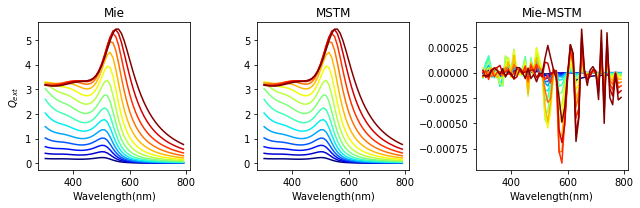

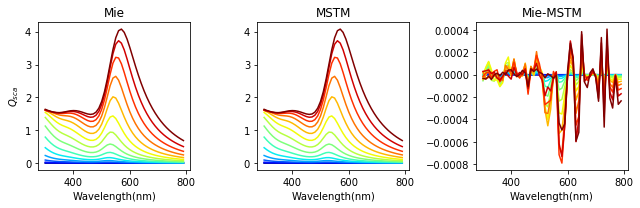

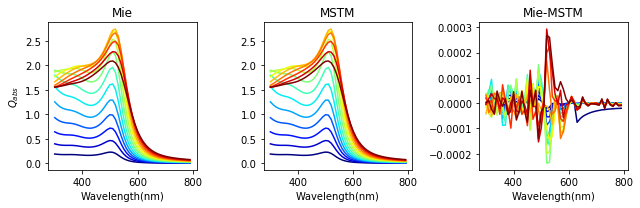

In [134]:
compare_mie(qextv,qextv2, wv2,dv2, ylabel="$Q_{ext}$")
compare_mie(qscav,qscav2, wv2,dv2, ylabel="$Q_{sca}$")
compare_mie(qabsv,qabsv2, wv2,dv2, ylabel="$Q_{abs}$")
plt.savefig(fileout)

We can confirm that we are using MSTM correctly. 

## to do 